In [ ]:
from medmnist import VesselMNIST3D
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
import gdown
import os
import random
import matplotlib.pyplot as plt
import sys
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

def take_middle_slice(inpt: np.ndarray):
    """
    NoduleMNIST 3D contains whole nodule volumes, however for this tutorial
    we will utilize only central slice of each example.
    We repeat this slice 3 times, as model expects input to have 3 channels.
    """
    inpt = inpt.squeeze()
    X, Y, Z = inpt.shape
    slice_ = inpt[:, :, Z//2]
    slice_ = torch.Tensor(slice_).unsqueeze(dim=0).repeat(3,1,1)
    return slice_

TRANSFORMS = v2.Compose([v2.Lambda(take_middle_slice),
                         v2.Resize(size=(224,224))
                         ])

data_dir = "./example_data"
os.makedirs(data_dir, exist_ok=True)


def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    
    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA"
output_dir = "tuned_models"
filename = "lidc_dino_s8.pth"
download_weights(url, output_dir, filename)

CLASS_NAMES = ["benign", "malignant"]

LOGIT2NAME = {
    0: "benign",
    1: "malignant",
}

train_data = VesselMNIST3D(root=data_dir, split="train", size=64, transform=TRANSFORMS, download=True)

zero_indices = [i for i, (_, label) in enumerate(train_data) if label == 0]
one_indices = [i for i, (_, label) in enumerate(train_data) if label == 1]

random.seed(42)
zero_indices_downsampled = random.sample(zero_indices, len(one_indices))

balanced_indices = zero_indices_downsampled + one_indices
random.shuffle(balanced_indices)

balanced_train_data = Subset(train_data, balanced_indices)
train_loader = DataLoader(balanced_train_data, batch_size=16, shuffle=True)

validation_data = VesselMNIST3D(root=data_dir, split="val", size=64, transform=TRANSFORMS, download=True) 
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))


val_loader = DataLoader(validation_data, batch_size=16, shuffle = False) 

test_dataset = VesselMNIST3D(root=data_dir, split="test", transform=TRANSFORMS)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

CLASS_NAMES = ["benign", "malignant"]

LOGIT2NAME = {
    0: "benign",
    1: "malignant",
}


c:\Users\Michał\Documents\Studia\StudiaMagisterskie\Bioinformatyka\RokISemII\CBS\medical_images
Weights already exist at tuned_models\lidc_dino_s8.pth. Skipping download.
length of Train Datasets:  1335
length of Validation Datasets:  191


In [2]:
from transformers import ViTConfig, ViTModel

class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    """
    def __init__(self):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # We propose eager implementation to return att scores gracefully.
        self.backbone = ViTModel(config)
        # Classfication head
        self.head = torch.nn.Linear(384, 1) # takes vector of length 384 and outputs 1 number
    
    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "./tuned_models/lidc_dino_s8.pth"

MODEL = DINO()
MODEL.to(DEVICE)

DINO(
  (backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, out_features=1536, bias=True)
            (intermediate_act_fn): GELUAc

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, pos_weight=self.pos_weight, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt = prob dla prawidłowej klasy
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()


num_pos: 150, num_neg: 150, pos_weight: 1.0000
loss: 0.04300834238529205
loss: 0.04325180500745773
loss: 0.043579354882240295
loss: 0.04682915657758713
loss: 0.04417857900261879
loss: 0.04481332749128342
loss: 0.043162751942873
loss: 0.04279378801584244
loss: 0.04281925782561302
loss: 0.047194704413414
loss: 0.041718997061252594
loss: 0.042780302464962006
loss: 0.046555232256650925
loss: 0.043366312980651855
loss: 0.043800704181194305
loss: 0.04212180897593498
loss: 0.044897936284542084
loss: 0.04256697744131088
loss: 0.04594413563609123
Epoch 1, Loss: 0.0440
preds (val): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
labels (val): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
preds (val): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
labels (val): [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
preds (val): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
labels (val): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
preds (val): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

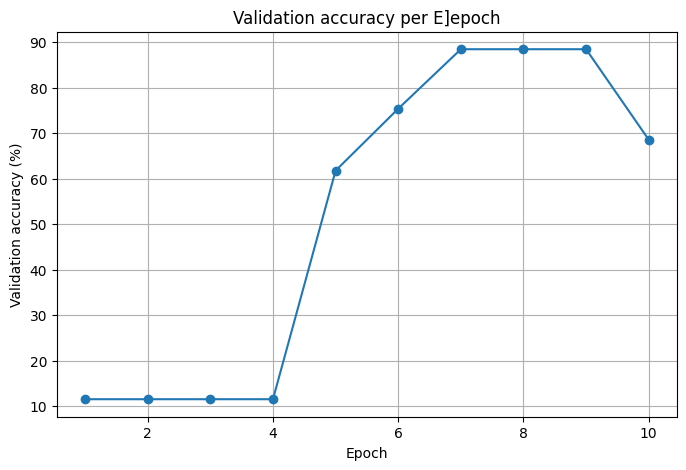

Test accuracy: 65.71%


In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(17)

optimizer = torch.optim.Adam(MODEL.parameters(), lr=1e-4)
num_epochs = 10

all_labels = []
for _, labels in train_loader:
    all_labels.append(labels)

all_labels = torch.cat(all_labels).float().to(DEVICE) 


num_pos = (all_labels == 1).sum().item()
num_neg = (all_labels == 0).sum().item()

pos_weight = torch.tensor(num_neg / num_pos).to(DEVICE)
criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)  # lub inne wartości
print(f"num_pos: {num_pos}, num_neg: {num_neg}, pos_weight: {pos_weight.item():.4f}")
val_accuracies = []

for epoch in range(num_epochs):
    MODEL.train()
    total_loss = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE).float().squeeze(1)
        optimizer.zero_grad()
        logits = MODEL(imgs).squeeze(1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        print("loss:", loss.item())

    avg_loss = total_loss / (batch_idx + 1)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    MODEL.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE).float()

            logits = MODEL(imgs)
            probs = torch.sigmoid(logits)
            preds = probs.round().squeeze().cpu().numpy()
            labels = labels.squeeze().cpu().numpy()
            correct += (preds == labels).sum()
            total += labels.shape[0]
            print("preds (val):", preds)
            print("labels (val):", labels)

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation accuracy: {val_acc:.2f}%")

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o')
plt.title("Validation accuracy per E]epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy (%)")
plt.grid(True)
plt.show()

MODEL.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE).float()

        logits = MODEL(imgs)
        probs = torch.sigmoid(logits)
        preds = probs.round().squeeze().cpu().numpy()
        labels = labels.squeeze().cpu().numpy()
        correct_test += (preds == labels).sum()
        total_test += labels.shape[0]

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")


In [11]:
#### When loading Obz, you may need to do:
## from obz.data_inspector.extractor import FirstOrderExtractor

# Setup OutlierDetector
from obzai.data_inspector.extractor import FirstOrderExtractor
from obzai.data_inspector.detector import GMMDetector
# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=[first_order_extrc], n_components=3, outlier_quantile=0.01)
# Call .fit() method with passed reference dataloader. 
# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(val_loader)



In [13]:
# Setup XAI Tools
## from obz.xai_tool import ...
from obzai.xai.xai_tool import CDAM, AttentionMap

# Choose desired XAI Tools
cdam_tool = CDAM(model=MODEL, 
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_logits",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.11.layernorm_before")

attention_tool = AttentionMap(model=MODEL,
                              attention_layer_id = -1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )

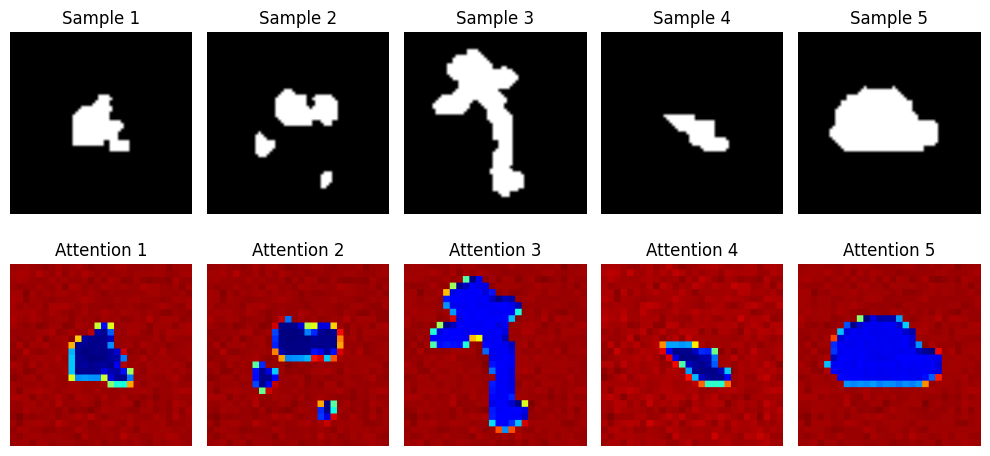

In [14]:
samples, labels = next(iter(val_loader))
attention_maps = attention_tool.explain(samples)

# Visualize samples and attention maps
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Attention maps
for i in range(5):
    attention_map = attention_maps[i].cpu().numpy()
    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

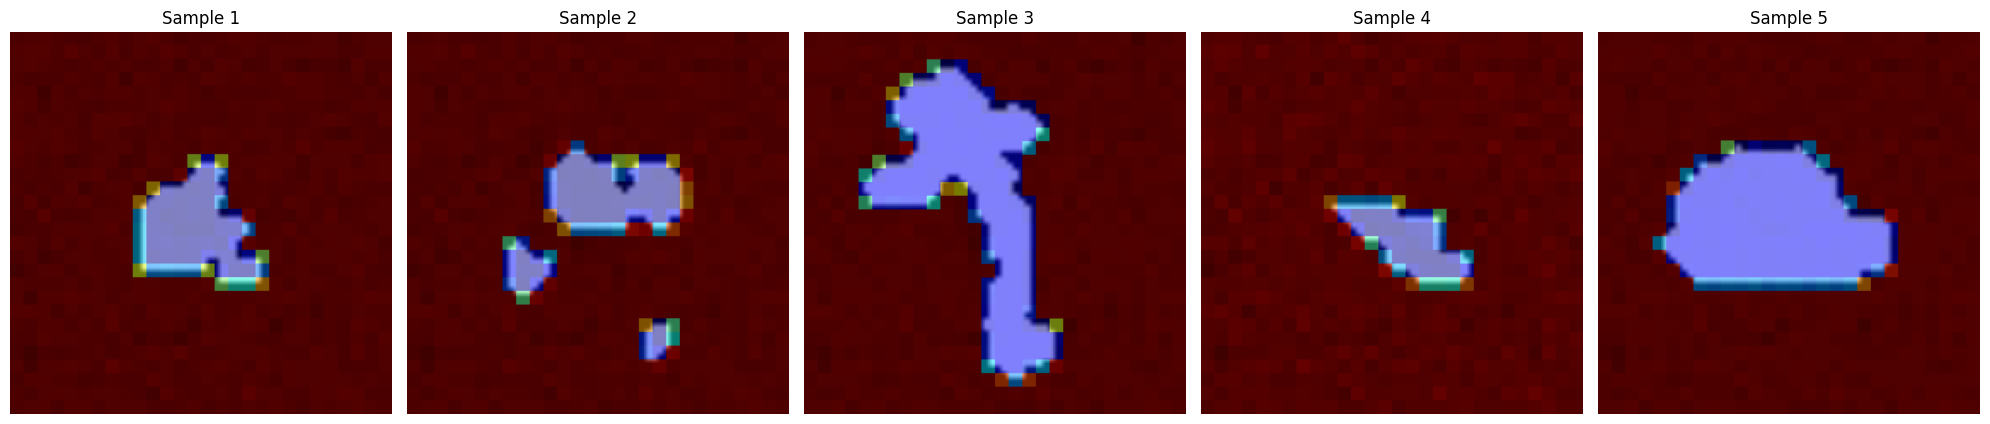

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    attention_map = attention_maps[i].cpu().numpy()  # Convert attention map to numpy array

    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)  # Use alpha for transparency
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
cdam_maps = cdam_tool.explain(samples, target_idx=[0]*len(samples))  

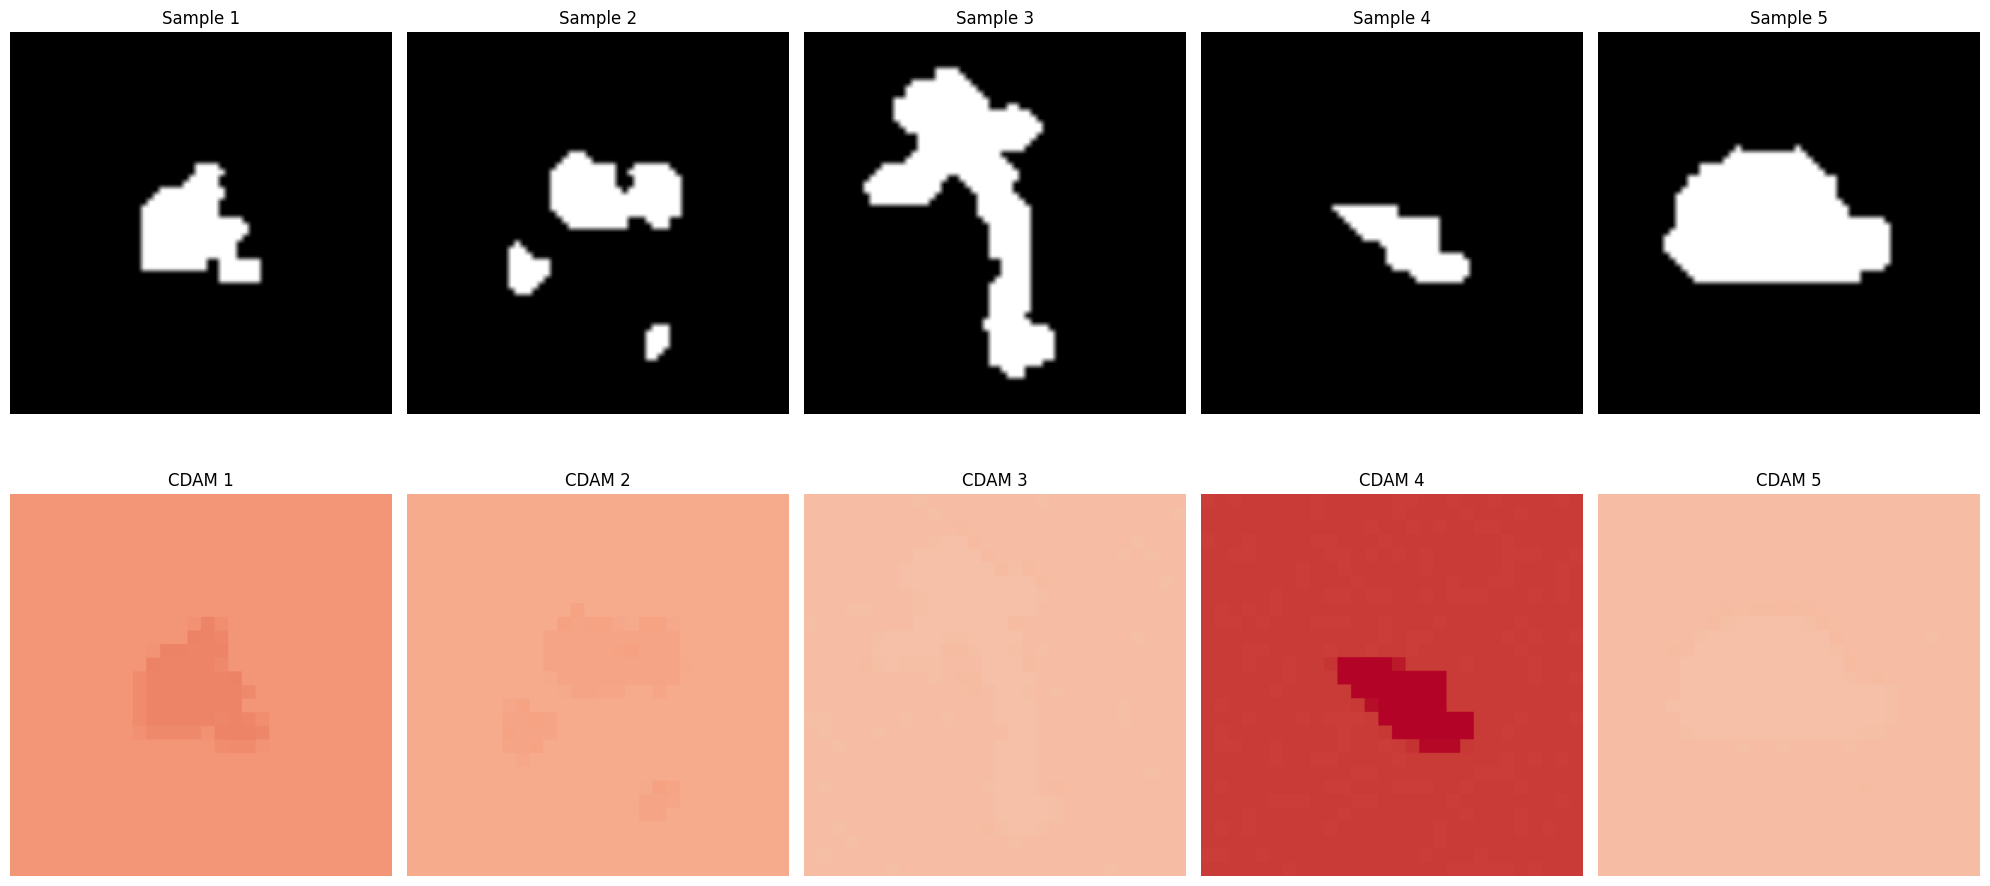

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Diverging colormap
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

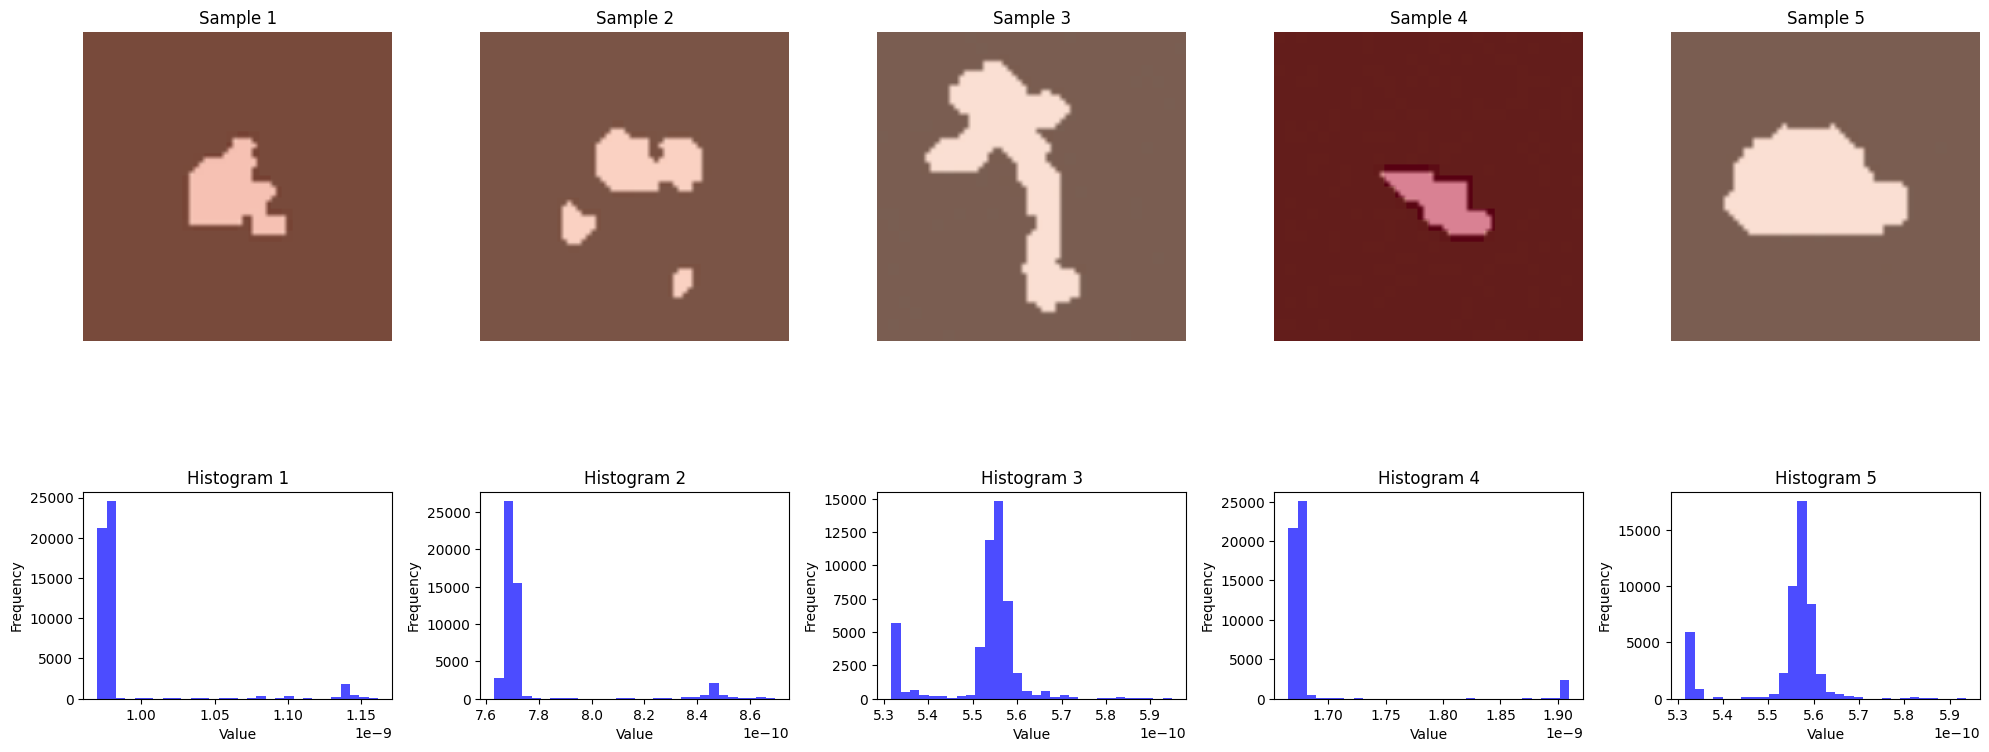

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  

    im = axes[0, i].imshow(original_image, cmap='gray')
    im = axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Use alpha for transparency
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  
    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()